## Strategy Comparison

Tasks:
- Load results from all strategies

Plot:
- Signal overlay on price chart
- Holdings over time
- Cash balance
- Total portfolio value
- Compare cumulative PnL across strategies
- Reflect on signal behavior, execution constraints, and performance

Required Charts:
- 📈 Signal overlay with buy markers
- 📊 Holdings, cash, and total assets over time
- 📉 Cumulative PnL comparison

In [17]:
# Import strategies and engine + other libraries 
import os
import pandas as pd
import matplotlib.pyplot as plt
from engine import MarketSimulation
from benchmark_strategy import BenchmarkStrategy
from moving_average_strategy import MAC
from volatility_breakout_strategy import VolatilityBreakoutStrategy
from macd_strategy import MACDStrategy
from rsi_strategy import RSIStrategy
from reporting import Reporting
import matplotlib.dates as mdates
from strategies import MarketDataPoint


In [4]:
# Instantiate strategies
strategies_dict = {
    "Benchmark": BenchmarkStrategy(),
    "MAC": MAC(20, 50),
    "MACD": MACDStrategy(),
    "RSI": RSIStrategy(),
    "Volatility Breakout": VolatilityBreakoutStrategy()
}

# Load symbols from data folder
symbols = [f.replace(".parquet", "") for f in os.listdir("data") if f.endswith(".parquet")]

results = {}  # Store NAV series for each strategy

initial_cash = 1000000
print("Running simulation for: Combined Strategies")
sim = MarketSimulation(cash_balance=initial_cash, strategies=list(strategies_dict.values()), symbols=symbols)
sim.run_simulation()
results["Combined Strategies"] = sim.NAV_series
for name, strategy in strategies_dict.items():
    print(f"Running simulation for: {name}")
    sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
    sim.run_simulation()
    results[name] = sim.NAV_series

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...
Simulation took 1.73 minutes
Running simulation for: Benchmark
Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...
Simulation took 0.10 minutes
Running simulation for: MAC
Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...

In [5]:
nav_df = pd.DataFrame(results)
nav_df.head()

,Combined Strategies,Benchmark,MAC,MACD,RSI,Volatility Breakout
2005-01-03,1000000.0,1000000,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06
2005-01-04,1000000.0,1000000,973618.436359,9.915061e+05,973618.427878,1.003324e+06
2005-01-05,1000000.0,1000000,982145.582312,1.003935e+06,973199.754676,1.019970e+06
2005-01-06,1000000.0,1000000,983747.590978,1.013671e+06,951843.564282,1.021645e+06
2005-01-07,1000000.0,1000000,985496.643175,1.007871e+06,951006.602394,1.023456e+06


Now that we have our strategies, we can observe the performance of them across either all of the 500 compnaies, or select stocks. Below are several pieces of code designed to help visualize PnL, performance, total portfolio value, and cash balances. 

# Example of Signal Overlay on Singular Equity Data

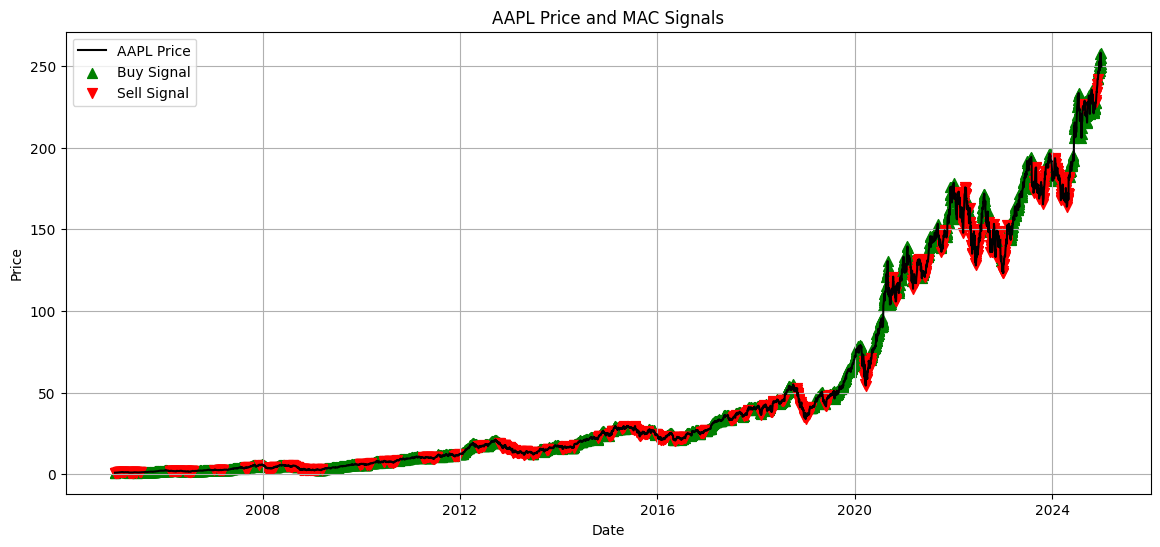

In [4]:
# Pick a symbol to visualize signals
symbol_to_plot = 'AAPL'

# Load price data for that symbol
price_df = pd.read_parquet(f"data/{symbol_to_plot}.parquet")

plt.figure(figsize=(14,6))
plt.plot(price_df.index, price_df['Close'], label=f"{symbol_to_plot} Price", color='black')

# Overlay buy/sell markers for one strategy (example: MAC)
strategy = strategies_dict["MAC"]
buy_dates = []
sell_dates = []

# Simple simulation for marker plotting
prev_position = 0
for idx, row in price_df.iterrows():
    tick = MarketDataPoint(idx, symbol_to_plot, row['Close'])
    signal = strategy.generate_signals(tick)[0]
    if signal == "BUY":
        buy_dates.append((idx, row['Close']))
    elif signal == "SELL":
        sell_dates.append((idx, row['Close']))

if buy_dates:
    plt.scatter(*zip(*buy_dates), marker='^', color='green', label='Buy Signal', s=50)
if sell_dates:
    plt.scatter(*zip(*sell_dates), marker='v', color='red', label='Sell Signal', s=50)

plt.title(f"{symbol_to_plot} Price and {strategy.__class__.__name__} Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Example of Signal Overlay on Every Equity Asset (MAC)
Note that the signal overlay can get messy/ confusing due to the volume of trades and equities we are dealing with

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


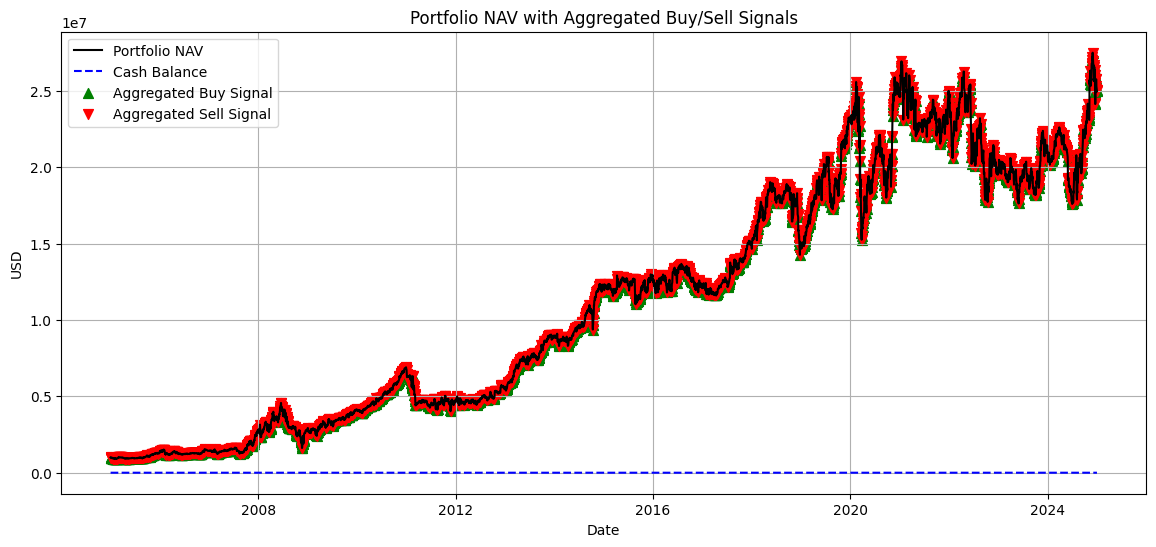

In [24]:
# Run simulation for strategy across all symbols
strategy = strategies_dict["MAC"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series([sim.cash_balance]*len(portfolio_value), index=portfolio_value.index)

# Aggregate daily buy/sell counts across all symbols
buy_counts = pd.Series(0, index=portfolio_value.index)
sell_counts = pd.Series(0, index=portfolio_value.index)

for symbol in symbols:
    price_df = pd.read_parquet(f"data/{symbol}.parquet")
    for idx, row in price_df.iterrows():
        tick = MarketDataPoint(idx, symbol, row['Close'])
        signal = strategy.generate_signals(tick)[0]
        if signal == "BUY":
            buy_counts[idx] += 1
        elif signal == "SELL":
            sell_counts[idx] += 1

# Plot portfolio NAV
plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio NAV', color='black')
plt.plot(cash_series.index, cash_series, label='Cash Balance', color='blue', linestyle='--')

# Overlay aggregated signals
plt.scatter(buy_counts[buy_counts > 0].index, 
            portfolio_value.loc[buy_counts > 0], 
            s=50, marker='^', color='green', label='Aggregated Buy Signal')
plt.scatter(sell_counts[sell_counts > 0].index, 
            portfolio_value.loc[sell_counts > 0], 
            s=50, marker='v', color='red', label='Aggregated Sell Signal')

plt.title("Portfolio NAV with Aggregated Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

# Example of Signal Overlay on Every Equity Asset (MACD)
Note that the signal overlay can get messy/ confusing due to the volume of trades and equities we are dealing with

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


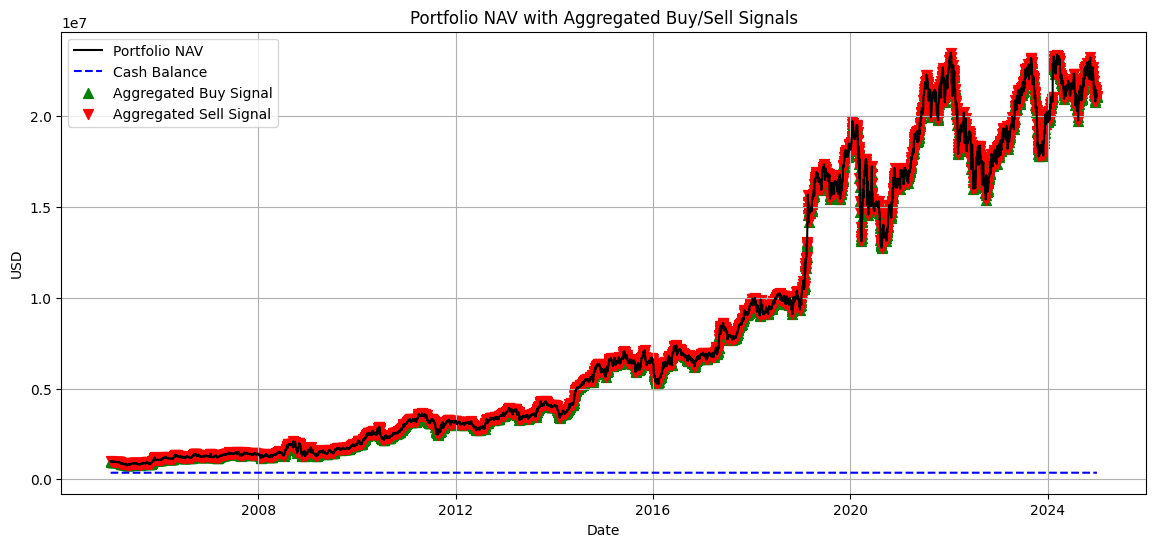

In [5]:
# Run simulation for strategy across all symbols
strategy = strategies_dict["MACD"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series([sim.cash_balance]*len(portfolio_value), index=portfolio_value.index)

# Aggregate daily buy/sell counts across all symbols
buy_counts = pd.Series(0, index=portfolio_value.index)
sell_counts = pd.Series(0, index=portfolio_value.index)

for symbol in symbols:
    price_df = pd.read_parquet(f"data/{symbol}.parquet")
    for idx, row in price_df.iterrows():
        tick = MarketDataPoint(idx, symbol, row['Close'])
        signal = strategy.generate_signals(tick)[0]
        if signal == "BUY":
            buy_counts[idx] += 1
        elif signal == "SELL":
            sell_counts[idx] += 1

# Plot portfolio NAV
plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio NAV', color='black')
plt.plot(cash_series.index, cash_series, label='Cash Balance', color='blue', linestyle='--')

# Overlay aggregated signals
plt.scatter(buy_counts[buy_counts > 0].index, 
            portfolio_value.loc[buy_counts > 0], 
            s=50, marker='^', color='green', label='Aggregated Buy Signal')
plt.scatter(sell_counts[sell_counts > 0].index, 
            portfolio_value.loc[sell_counts > 0], 
            s=50, marker='v', color='red', label='Aggregated Sell Signal')

plt.title("Portfolio NAV with Aggregated Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

# Example of Signal Overlay on Every Equity Asset (RSI)
Note that the signal overlay can get messy/ confusing due to the volume of trades and equities we are dealing with

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


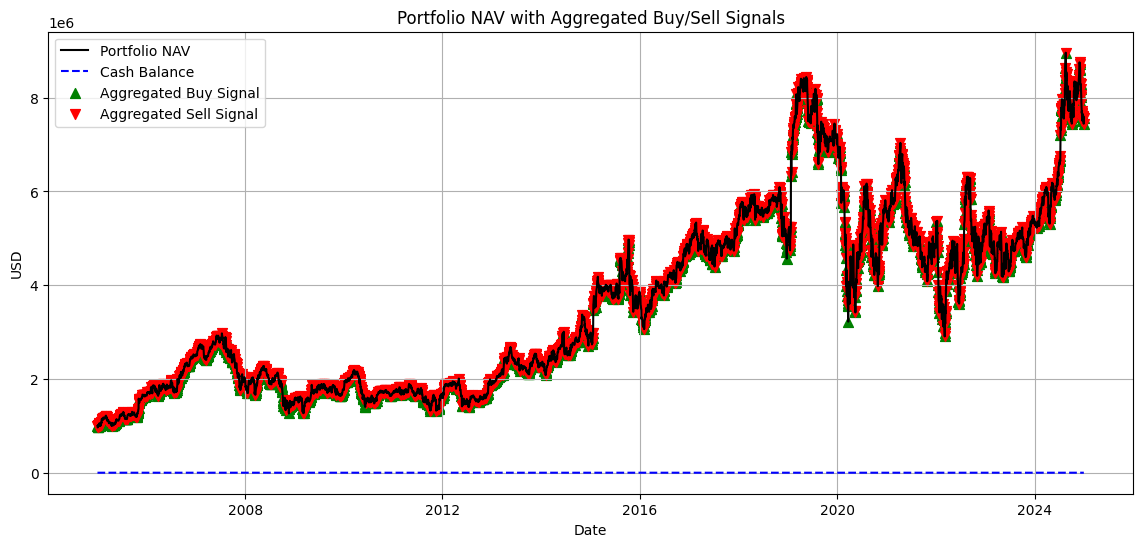

In [37]:
# Run simulation for strategy across all symbols
strategy = strategies_dict["RSI"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series([sim.cash_balance]*len(portfolio_value), index=portfolio_value.index)

# Aggregate daily buy/sell counts across all symbols
buy_counts = pd.Series(0, index=portfolio_value.index)
sell_counts = pd.Series(0, index=portfolio_value.index)

for symbol in symbols:
    price_df = pd.read_parquet(f"data/{symbol}.parquet")
    for idx, row in price_df.iterrows():
        tick = MarketDataPoint(idx, symbol, row['Close'])
        signal = strategy.generate_signals(tick)[0]
        if signal == "BUY":
            buy_counts[idx] += 1
        elif signal == "SELL":
            sell_counts[idx] += 1

# Plot portfolio NAV
plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio NAV', color='black')
plt.plot(cash_series.index, cash_series, label='Cash Balance', color='blue', linestyle='--')

# Overlay aggregated signals
plt.scatter(buy_counts[buy_counts > 0].index, 
            portfolio_value.loc[buy_counts > 0], 
            s=50, marker='^', color='green', label='Aggregated Buy Signal')
plt.scatter(sell_counts[sell_counts > 0].index, 
            portfolio_value.loc[sell_counts > 0], 
            s=50, marker='v', color='red', label='Aggregated Sell Signal')

plt.title("Portfolio NAV with Aggregated Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

# Example of Signal Overlay on Every Equity Asset (Benchmark)
Note that the signal overlay can get messy/ confusing due to the volume of trades and equities we are dealing with

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


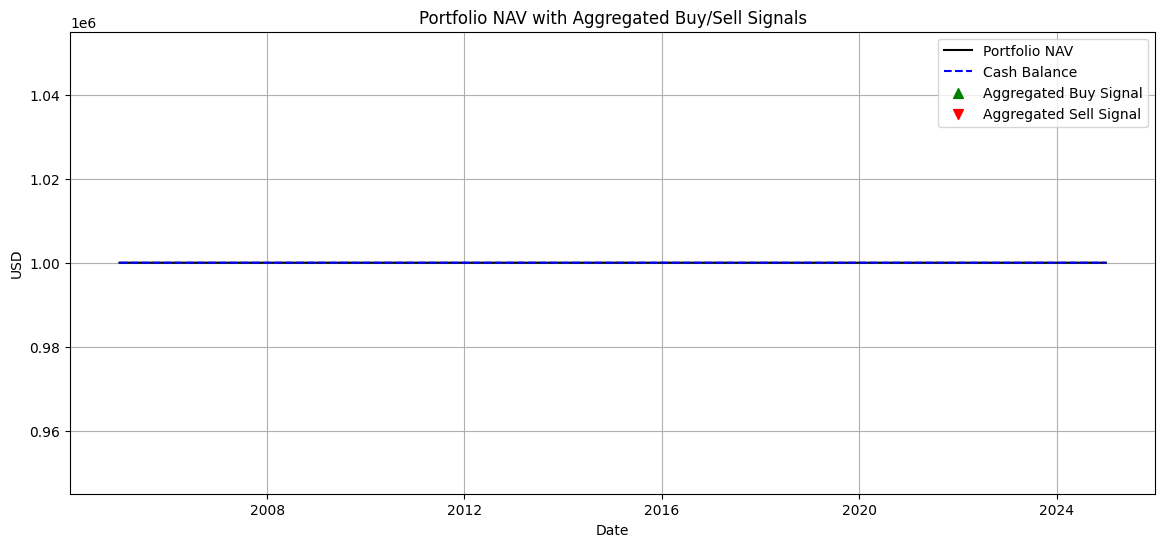

In [42]:
# Run simulation for strategy across all symbols
strategy = strategies_dict["Benchmark"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series([sim.cash_balance]*len(portfolio_value), index=portfolio_value.index)

# Aggregate daily buy/sell counts across all symbols
buy_counts = pd.Series(0, index=portfolio_value.index)
sell_counts = pd.Series(0, index=portfolio_value.index)

for symbol in symbols:
    price_df = pd.read_parquet(f"data/{symbol}.parquet")
    for idx, row in price_df.iterrows():
        tick = MarketDataPoint(idx, symbol, row['Close'])
        signal = strategy.generate_signals(tick)[0]
        if signal == "BUY":
            buy_counts[idx] += 1
        elif signal == "SELL":
            sell_counts[idx] += 1

# Plot portfolio NAV
plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio NAV', color='black')
plt.plot(cash_series.index, cash_series, label='Cash Balance', color='blue', linestyle='--')

# Overlay aggregated signals
plt.scatter(buy_counts[buy_counts > 0].index, 
            portfolio_value.loc[buy_counts > 0], 
            s=50, marker='^', color='green', label='Aggregated Buy Signal')
plt.scatter(sell_counts[sell_counts > 0].index, 
            portfolio_value.loc[sell_counts > 0], 
            s=50, marker='v', color='red', label='Aggregated Sell Signal')

plt.title("Portfolio NAV with Aggregated Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

# Example of Signal Overlay on Every Equity Asset (Volatility Breakout)
Note that the signal overlay can get messy/ confusing due to the volume of trades and equities we are dealing with

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


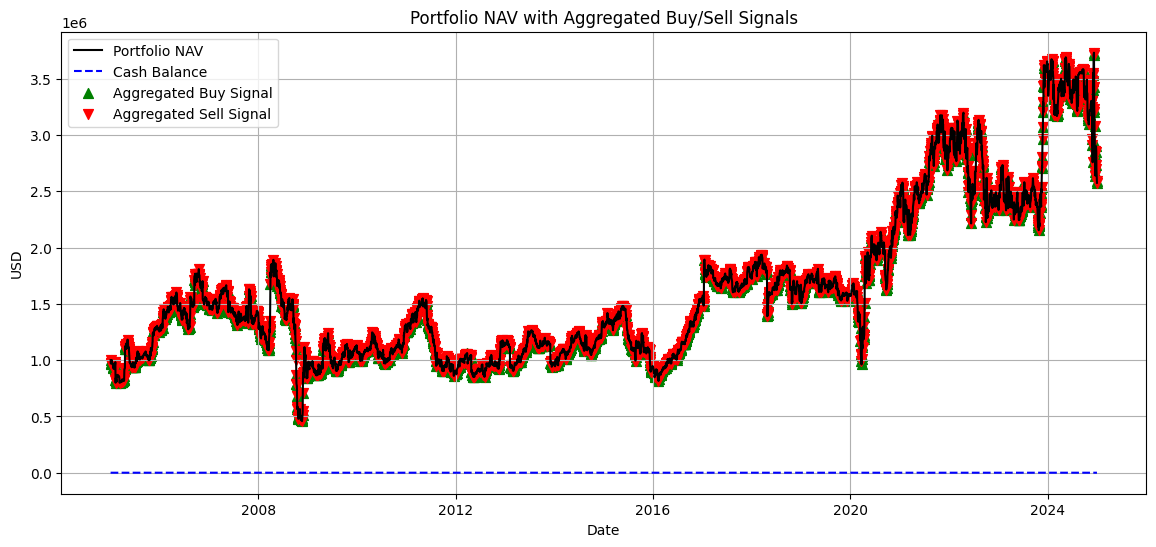

In [6]:
# Run simulation for strategy across all symbols
strategy = strategies_dict["Volatility Breakout"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series([sim.cash_balance]*len(portfolio_value), index=portfolio_value.index)

# Aggregate daily buy/sell counts across all symbols
buy_counts = pd.Series(0, index=portfolio_value.index)
sell_counts = pd.Series(0, index=portfolio_value.index)

for symbol in symbols:
    price_df = pd.read_parquet(f"data/{symbol}.parquet")
    for idx, row in price_df.iterrows():
        tick = MarketDataPoint(idx, symbol, row['Close'])
        signal = strategy.generate_signals(tick)[0]
        if signal == "BUY":
            buy_counts[idx] += 1
        elif signal == "SELL":
            sell_counts[idx] += 1

# Plot portfolio NAV
plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio NAV', color='black')
plt.plot(cash_series.index, cash_series, label='Cash Balance', color='blue', linestyle='--')

# Overlay aggregated signals
plt.scatter(buy_counts[buy_counts > 0].index, 
            portfolio_value.loc[buy_counts > 0], 
            s=50, marker='^', color='green', label='Aggregated Buy Signal')
plt.scatter(sell_counts[sell_counts > 0].index, 
            portfolio_value.loc[sell_counts > 0], 
            s=50, marker='v', color='red', label='Aggregated Sell Signal')

plt.title("Portfolio NAV with Aggregated Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

# Example of Signal Overlay on Every Equity Asset (Combined Strategies)
Note that the signal overlay can get messy/ confusing due to the volume of trades and equities we are dealing with

In [ ]:
# Run simulation for strategy across all symbols
sim = MarketSimulation(cash_balance=initial_cash, strategies=list(strategies_dict.values()), symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series([sim.cash_balance]*len(portfolio_value), index=portfolio_value.index)

# Aggregate daily buy/sell counts across all symbols
buy_counts = pd.Series(0, index=portfolio_value.index)
sell_counts = pd.Series(0, index=portfolio_value.index)

for symbol in symbols:
    price_df = pd.read_parquet(f"data/{symbol}.parquet")
    for idx, row in price_df.iterrows():
        tick = MarketDataPoint(idx, symbol, row['Close'])
        signal = strategy.generate_signals(tick)[0]
        if signal == "BUY":
            buy_counts[idx] += 1
        elif signal == "SELL":
            sell_counts[idx] += 1

# Plot portfolio NAV
plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio NAV', color='black')
plt.plot(cash_series.index, cash_series, label='Cash Balance', color='blue', linestyle='--')

# Overlay aggregated signals
plt.scatter(buy_counts[buy_counts > 0].index,
            portfolio_value.loc[buy_counts > 0],
            s=50, marker='^', color='green', label='Aggregated Buy Signal')
plt.scatter(sell_counts[sell_counts > 0].index,
            portfolio_value.loc[sell_counts > 0],
            s=50, marker='v', color='red', label='Aggregated Sell Signal')

plt.title("Portfolio NAV with Aggregated Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...


# Cash and Total Asset (MAC)

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


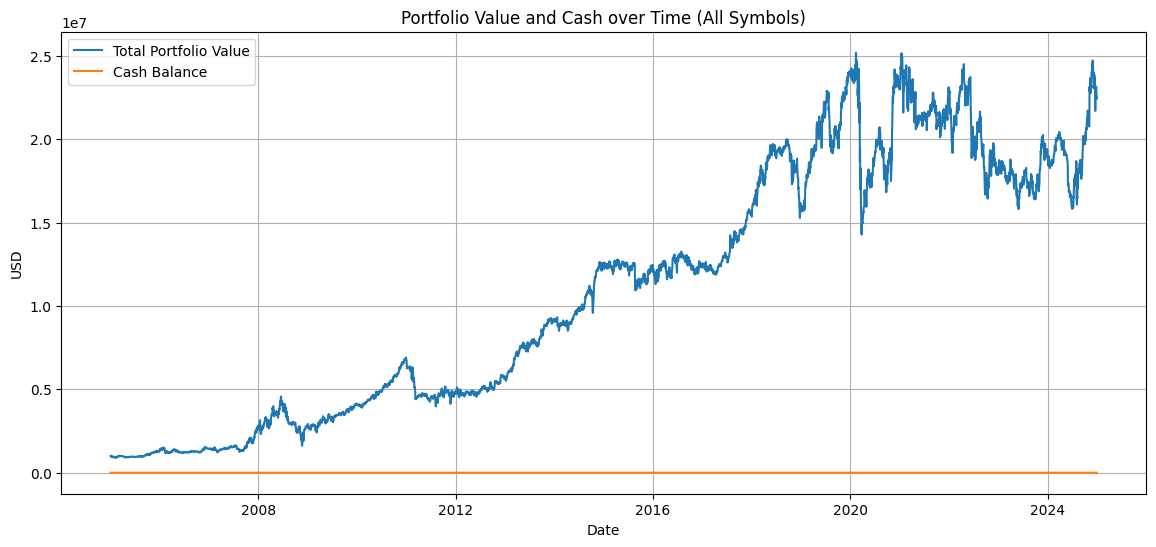

In [16]:
# Run simulation for strategy across all symbols at once
strategy = strategies_dict["MAC"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series(sim.cash_history, index=portfolio_value.index)

plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Total Portfolio Value')
plt.plot(cash_series.index, cash_series, label='Cash Balance')
plt.title("Portfolio Value and Cash over Time (All Symbols)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

# Cash and Total Asset (Volatility Breakout)

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


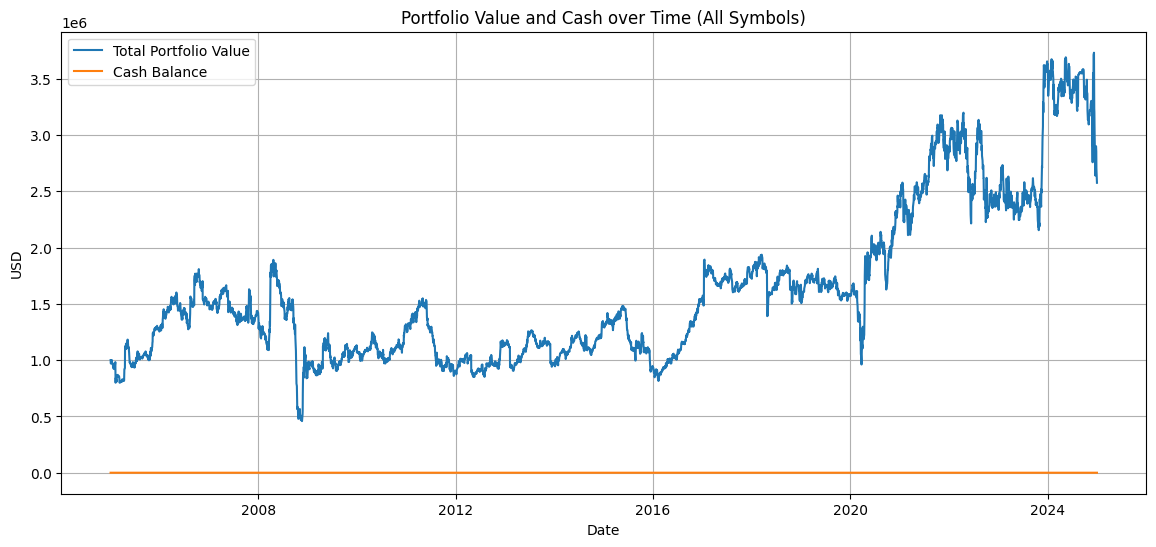

In [19]:
# Run simulation for strategy across all symbols at once
strategy = strategies_dict["Volatility Breakout"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series(sim.cash_history, index=portfolio_value.index)

plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Total Portfolio Value')
plt.plot(cash_series.index, cash_series, label='Cash Balance')
plt.title("Portfolio Value and Cash over Time (All Symbols)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()


# Cash and Total Asset (Benchmark)

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


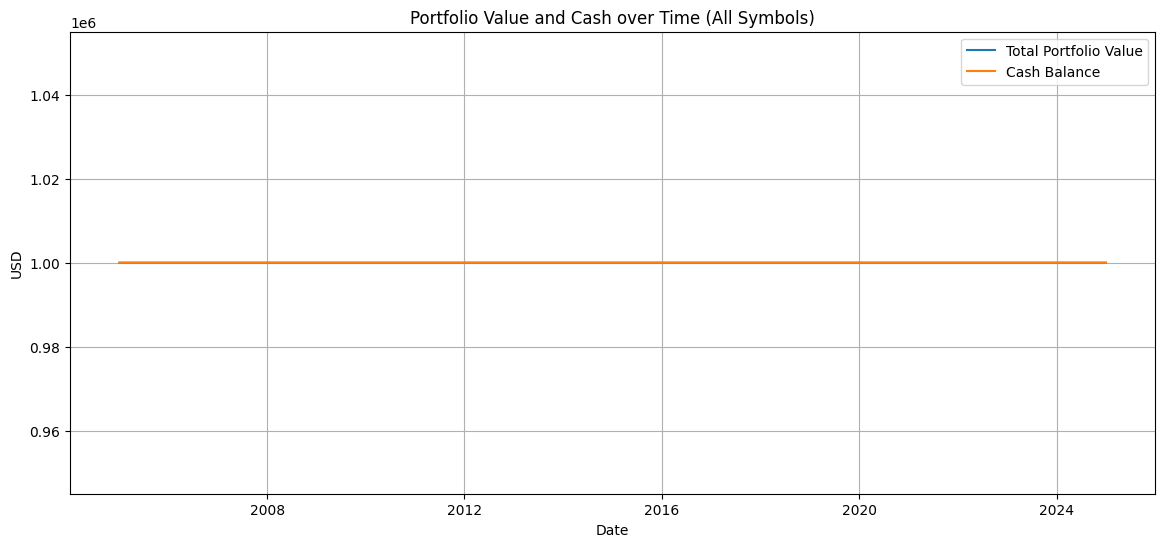

In [20]:
# Run simulation for strategy across all symbols at once
strategy = strategies_dict["Benchmark"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series(sim.cash_history, index=portfolio_value.index)

plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Total Portfolio Value')
plt.plot(cash_series.index, cash_series, label='Cash Balance')
plt.title("Portfolio Value and Cash over Time (All Symbols)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()


# Cash and Total Asset (MACD)

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...


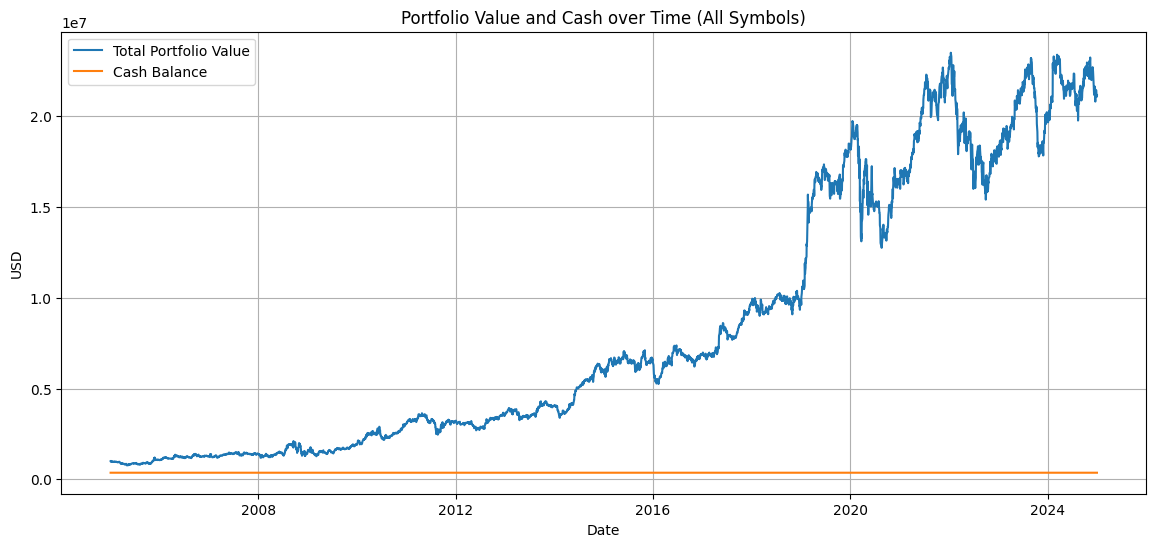

In [21]:
# Run simulation for strategy across all symbols at once
strategy = strategies_dict["MACD"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series(sim.cash_history, index=portfolio_value.index)

plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Total Portfolio Value')
plt.plot(cash_series.index, cash_series, label='Cash Balance')
plt.title("Portfolio Value and Cash over Time (All Symbols)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()


# Cash and Total Asset (RSI)

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...
Simulation took 0.29 minutes


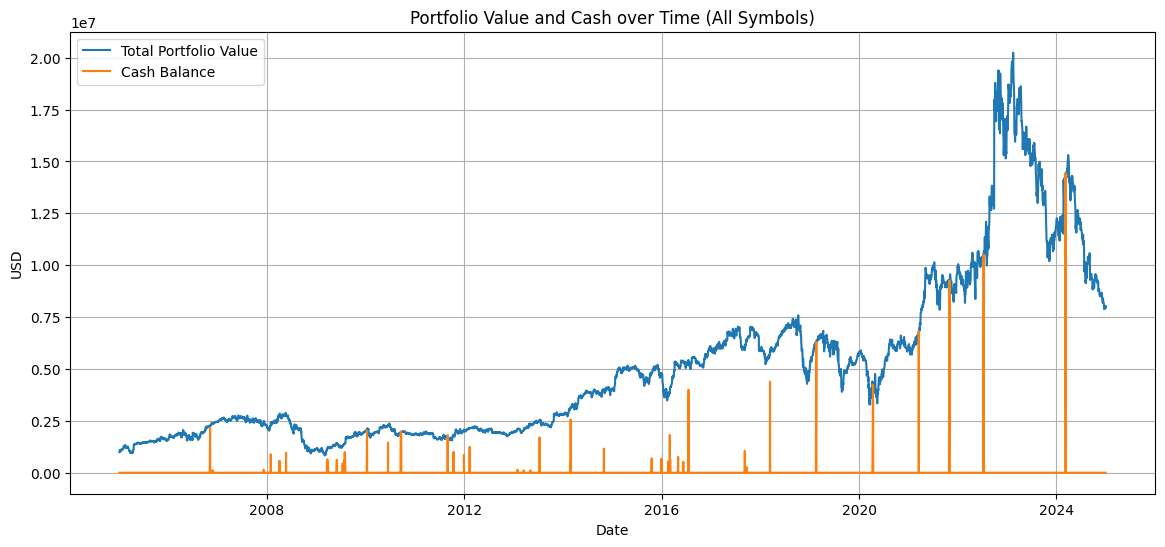

In [14]:
# Run simulation for strategy across all symbols at once
strategy = strategies_dict["RSI"]
sim = MarketSimulation(cash_balance=initial_cash, strategies=[strategy], symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series(sim.cash_history, index=portfolio_value.index)

plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Total Portfolio Value')
plt.plot(cash_series.index, cash_series, label='Cash Balance')
plt.title("Portfolio Value and Cash over Time (All Symbols)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()


# Cash and Total Asset (Combined)

Loading data...
Data loaded...
Running simulation...
Simulation 0.0% complete...
Simulation 10.0% complete...
Simulation 20.0% complete...
Simulation 30.0% complete...
Simulation 40.0% complete...
Simulation 50.0% complete...
Simulation 60.0% complete...
Simulation 70.0% complete...
Simulation 80.0% complete...
Simulation 89.9% complete...
Simulation 99.9% complete...
Simulation took 2.08 minutes


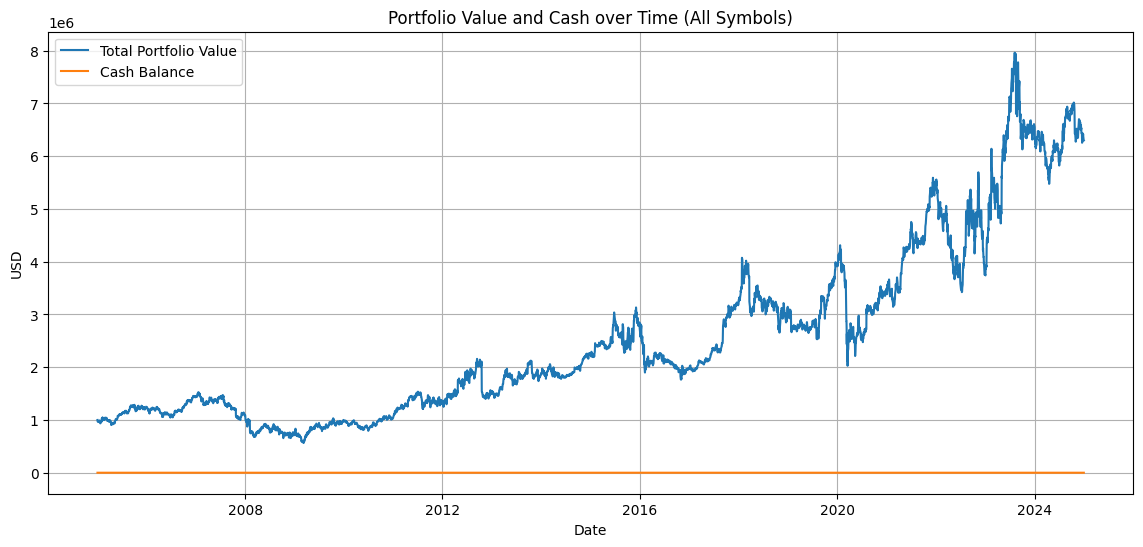

In [11]:
# Run simulation for strategy across all symbols at once
sim = MarketSimulation(cash_balance=initial_cash, strategies=list(strategies_dict.values()), symbols=symbols)
sim.run_simulation()

portfolio_value = sim.NAV_series
cash_series = pd.Series(sim.cash_history, index=portfolio_value.index)

plt.figure(figsize=(14,6))
plt.plot(portfolio_value.index, portfolio_value, label='Total Portfolio Value')
plt.plot(cash_series.index, cash_series, label='Cash Balance')
plt.title("Portfolio Value and Cash over Time (All Symbols)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()


# PnL Comparison Across All Strategies For All Companies

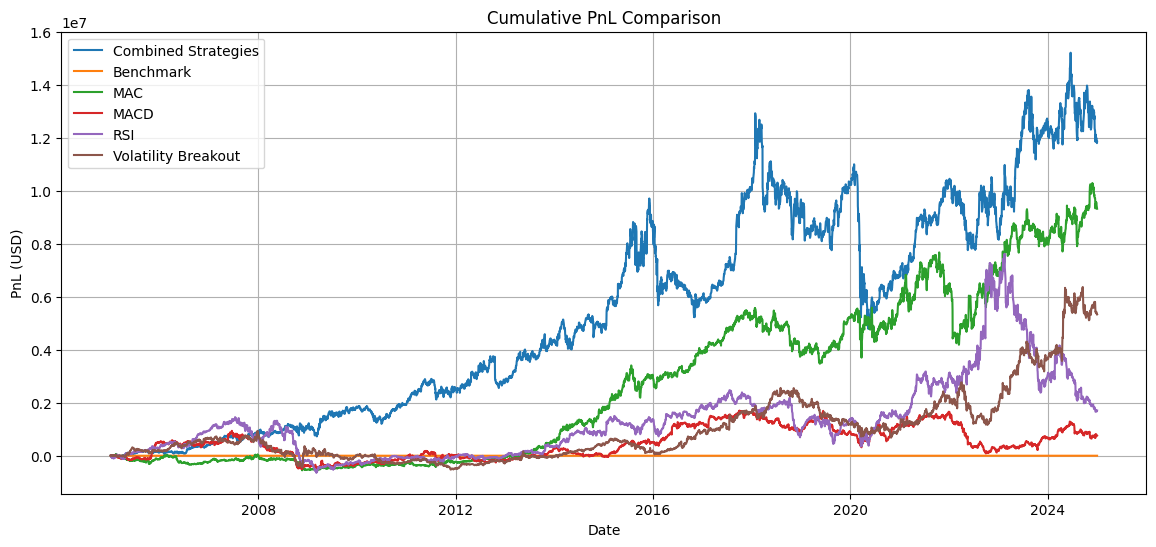

In [7]:
plt.figure(figsize=(14,6))
for name, nav in results.items():
    pnl = nav - initial_cash
    plt.plot(pnl.index, pnl, label=name)

plt.title("Cumulative PnL Comparison")
plt.xlabel("Date")
plt.ylabel("PnL (USD)")
plt.legend()
plt.grid(True)
plt.show()